In [1]:
#### Inizializza repository settare in modon concorde il path dei dati, il path del repository e 
#### le altre variabili d'ambiente all'interno del file .env

from dotenv import load_dotenv
import os
import sys
import lightning as pl
load_dotenv()  # legge il file .env
repo_path = os.getenv("REPO_PATH")
sys.path.append(repo_path)
os.chdir(repo_path)
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
from utils import util
from models.utils import save_image
from data.transforms import get_transforms
from data.datautils import CT2MRfindImages,MR2CTfindImages
from monai.data import DataLoader, CacheDataset
import matplotlib.pyplot as plt
from models.pix2pix import Pix2Pix


/opt/conda/envs/monai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
experiment_path = "experiments/CT2MR/options_4.yaml" ### set experiment path
with open(experiment_path, 'r') as file:
    options = yaml.safe_load(file)

dataset_option = util.DotDict(options['data'])
opt = util.DotDict(options)

## Dataset

In [4]:
test_transforms = get_transforms(dataset_option.validation)

AttributeError: 'DotDict' object has no attribute 'fix_pose'

In [ ]:
if opt.training.direction == "CTtoMR" : 
    test_image_paths = CT2MRfindImages(dataset_option.basic_information,True)
elif opt.training.direction == "MRtoCT" : 
    test_image_paths = MR2CTfindImages(dataset_option.basic_information,True)


In [ ]:
test_dataset = CacheDataset(
    data=test_image_paths,
    transform=test_transforms,
    cache_rate=dataset_option.train.cache_rate,
    num_workers=dataset_option.train.cacheDataset_num_workers,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=dataset_option.validation.batch_size,
    shuffle=False,
    num_workers=dataset_option.train.dataLoader_num_workers,
    pin_memory=False,
)

Loading dataset: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


In [ ]:
sample = next(iter(test_dataloader))

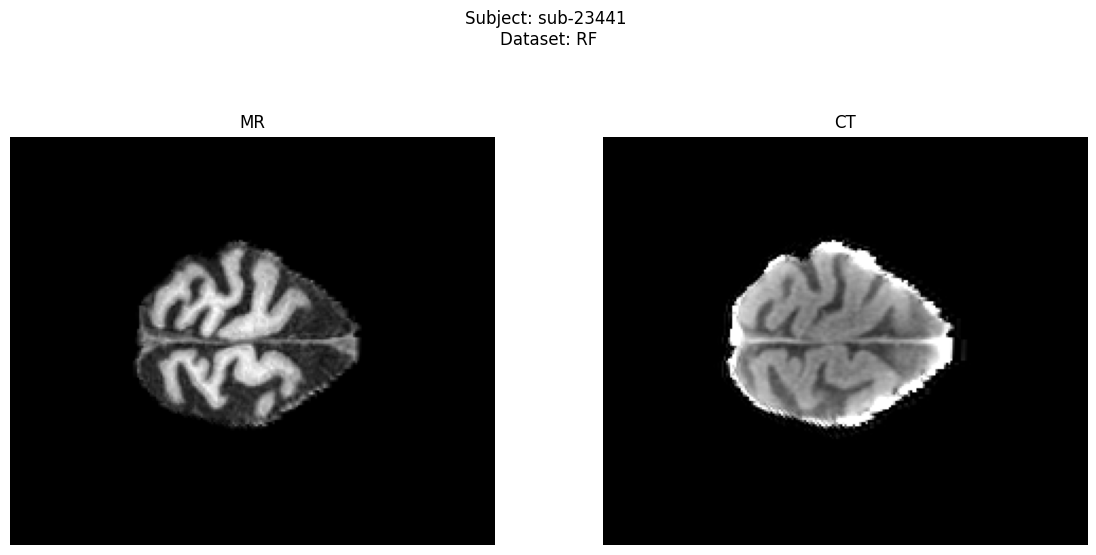

In [8]:
i = 0
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("MR")
plt.imshow(sample["MR"].cpu()[i,0,:,:,150], cmap="gray")
plt.axis(False)
plt.subplot(1,2,2)
plt.title("CT")
plt.imshow(sample["CT"].cpu()[i,0,:,:,150], cmap="gray")
plt.axis(False)
plt.suptitle(f"Subject: {sample['subject'][i]} \nDataset: {sample['dataset'][i]}", y=1.1)
plt.tight_layout()
plt.show()

## Model

In [10]:
opt = util.DotDict(options)
ckpt_path = os.path.join(opt.logging.save_dir,opt.training.direction,f"version_{str(opt.experiment_number)}","checkpoints")
ckpt_path = [os.path.join(ckpt_path,x) for x in os.listdir(ckpt_path) if "best" in x][0]



In [12]:
model = Pix2Pix.load_from_checkpoint(ckpt_path, opt=opt, strict=False)

unet_128
initialize network with normal
initialize network with normal


In [13]:
from monai.inferers import SlidingWindowInferer
from tqdm import tqdm
import torch
from monai.metrics import  MAEMetric, PSNRMetric, MultiScaleSSIMMetric,SSIMMetric


def set_input( input_batch,device,direction): # Renamed for clarity
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input_batch (dict): include the data itself and its metadata information.

        The option 'direction' can be used to swap images in domain A and domain B.
        """
        AtoB = direction == 'CTtoMR' # Simplified boolean assignment

        # Ensure inputs are moved to the correct device. self.device is managed by Lightning.
        real_A = input_batch['CT' if AtoB else 'MR'].to(device)
        real_B = input_batch['MR' if AtoB else 'CT'].to(device)
        mask = input_batch['MASK'].to(device) if 'MASK' in input_batch else None
        patient_information = [{"subject": x, "dataset": y} for x,y in zip(input_batch["subject"],input_batch["dataset"])]
        return real_A,real_B,mask,patient_information


def test_model(model,device,dataloader,opt) :
    
    sw_inferer = SlidingWindowInferer(
        roi_size=(128,128,128),
        sw_batch_size=1,
        overlap=0.5,
        mode="gaussian")
    model.to(device)
    mae_metric = MAEMetric(reduction="mean")
    psnr_metric = PSNRMetric(max_val=1)
    ssim_metric = SSIMMetric(spatial_dims=3)
    mmsim_metri = MultiScaleSSIMMetric(spatial_dims = 3)
    with torch.no_grad():
        model.eval()
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            direction = opt.training.direction
            input_image,target_image,_,subject_information = set_input(batch,device,direction)
            output_image = sw_inferer(input_image,network = model)
            mae_metric(output_image, target_image)
            psnr_metric(output_image, target_image)
            ssim_metric(output_image, target_image)
            ####
            mae = mae_metric.aggregate().item()
            psnr = psnr_metric.aggregate().item()
            ssim = ssim_metric.aggregate().item()
            mmsim = mmsim_metri(output_image, target_image).item()
            metrics = {
                "MAE": mae,
                "PSNR": psnr,
                "SSIM": ssim,
                "MM-SSIm" : mmsim
            }
            output_dir = os.path.join(opt.logging.save_dir,opt.training.direction,f"version_{str(opt.experiment_number)}","test_results")
            save_image(input_image[0], target_image[0], output_image[0], subject_information[0],output_dir,metrics)
            mae_metric.reset()
            psnr_metric.reset()
            ssim_metric.reset()
            mmsim_metri.reset()

In [14]:
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu") 
test_model(model.netG,device,test_dataloader,opt)

100%|██████████| 289/289 [17:55<00:00,  3.72s/it]
